## Setup

In [199]:
import jax
import numpy as np
import descwl_shear_sims
import lsst.afw
import matplotlib.pyplot as plt 
import galsim as _galsim

In [200]:
jax.__version__, _galsim.__version__

('0.4.13', '2.4.10')

In [201]:
# Working in float64
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

In [202]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random

## Fit single galaxy from galsim (no shear)

### global params

In [104]:
PSF_HLR = 1.2
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e3
NOISE = 1

# galaxy
HLR = 0.9
TRUE_FLUX = 1e5

### functions

In [111]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=HLR)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    img = gal_conv.array + BACKGROUND
    img += np.random.randn(*img.shape) * np.sqrt(img) * NOISE
    return img

In [112]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(flux):
    gal = galsim.Gaussian(flux=flux, half_light_radius=HLR)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    gal_conv += BACKGROUND
    return gal_conv.array

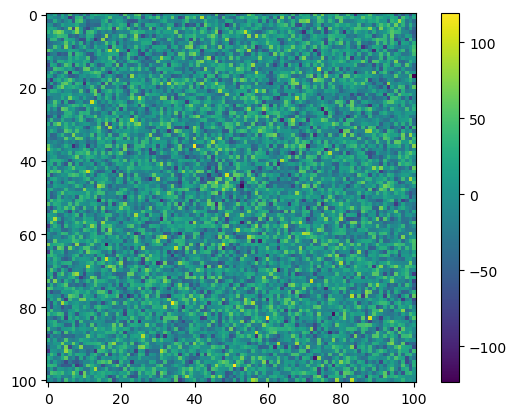

In [113]:
# check error is very small on true thingies
f = jnp.array([TRUE_FLUX])
arr = _draw_gal() - draw_gal(f)[0]
plt.imshow(arr)
plt.colorbar()

### Fit!

In [246]:
TRUE_IMAGE = _draw_gal(TRUE_FLUX)
TRUE_IMAGE.shape

(101, 101)

In [247]:
def prob_model(y=None):
    flux = numpyro.sample('f', dist.Normal(1e5, 3e3))
    im = draw_gal(jnp.array([flux]))
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(im)), obs=y)

In [248]:
nuts_kernel = NUTS(prob_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, y=TRUE_IMAGE)

sample: 100%|██████████| 3000/3000 [01:00<00:00, 49.77it/s, 3 steps of size 1.01e+00. acc. prob=0.93] 


In [254]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         f 100145.45    757.64 100146.89  98861.21 101336.23    681.17      1.00

Number of divergences: 0


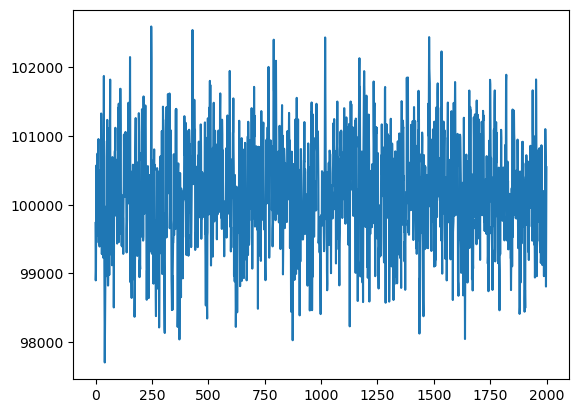

In [253]:
plt.plot(mcmc.get_samples()['f'])

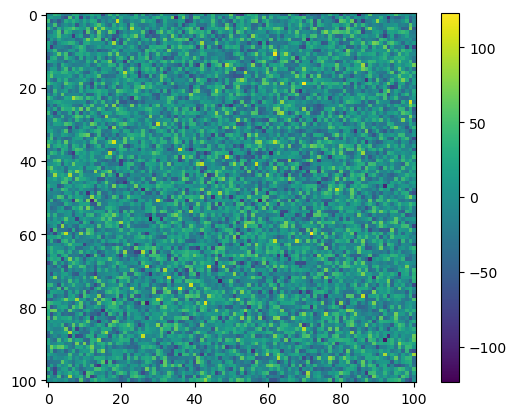

In [255]:
f = mcmc.get_samples()['f'][-1]
plt.imshow(draw_gal(jnp.array([f]))[0] - TRUE_IMAGE)
plt.colorbar()

## Fit single gaussian galaxy with shear (and other parameters)

In [218]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 102
BACKGROUND = 10
NOISE = 1

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 5
TRUE_FLUX = 10**LOG_TRUE_FLUX
TRUE_X = 0.5
TRUE_Y = 0.5
 
#shear
G1 = 0.02
G2 = 0.0

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR, 'x': TRUE_X, 'y': TRUE_Y, 'g1': G1, 'g2': G2}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}

In [219]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    gal = gal.shear(g1=G1, g2=G2)
    pos = _galsim.PositionD(x=TRUE_X, y=TRUE_Y)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos,
                                 )
    img = gal_conv.array + BACKGROUND
    img += np.random.randn(*img.shape) * np.sqrt(BACKGROUND) * NOISE
    return img

In [220]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf, hlr, x, y, g1, g2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos, 
                                 )
    im = gal_conv.array + BACKGROUND
    return im

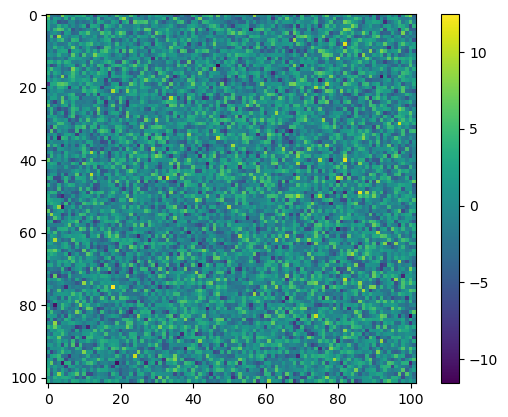

In [221]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gal()
arr = TRUE_IMAGE - draw_gal(**TRUE_PARAMS_ARR)[0]
plt.imshow(arr)
plt.colorbar()

In [222]:
## TEST with target image for jax-galsim.
# img = draw_gal(**TRUE_PARAMS_ARR)[0]
# TRUE_IMAGE += np.random.randn(*img.shape) * np.sqrt(BACKGROUND) * NOISE

In [223]:
def prob_model(y=None):
    params = {
        'lf': numpyro.sample('lf', dist.Uniform(4,6)),
        'hlr': numpyro.sample('hlr', dist.Uniform(0.7, 1.2)),
        'x': numpyro.sample('x', dist.Uniform(-1, 1)),
        'y': numpyro.sample('y', dist.Uniform(-1, 1)),
        'g1':numpyro.sample('g1', dist.Uniform(-0.05, 0.05)),
        'g2':numpyro.sample('g2', dist.Uniform(-0.05, 0.05)),
    }
    params = {k:jnp.array([v]) for k,v in params.items()}
    im = draw_gal(**params)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(im)), obs=y)

In [224]:
nuts_kernel = NUTS(prob_model, max_tree_depth=5) 
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, y=TRUE_IMAGE)

sample: 100%|██████████| 2500/2500 [05:08<00:00,  8.09it/s, 7 steps of size 4.90e-01. acc. prob=0.92] 


In [225]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        g1      0.02      0.00      0.02      0.02      0.03   2622.94      1.00
        g2      0.00      0.00      0.00     -0.00      0.01   2325.59      1.00
       hlr      0.90      0.00      0.90      0.89      0.90   2445.42      1.00
        lf      5.00      0.00      5.00      5.00      5.00   2435.83      1.00
         x      0.51      0.02      0.51      0.49      0.54   1903.54      1.00
         y      0.49      0.02      0.49      0.46      0.51   2324.88      1.00

Number of divergences: 0


In [226]:
mcmc.get_samples().keys()

dict_keys(['g1', 'g2', 'hlr', 'lf', 'x', 'y'])

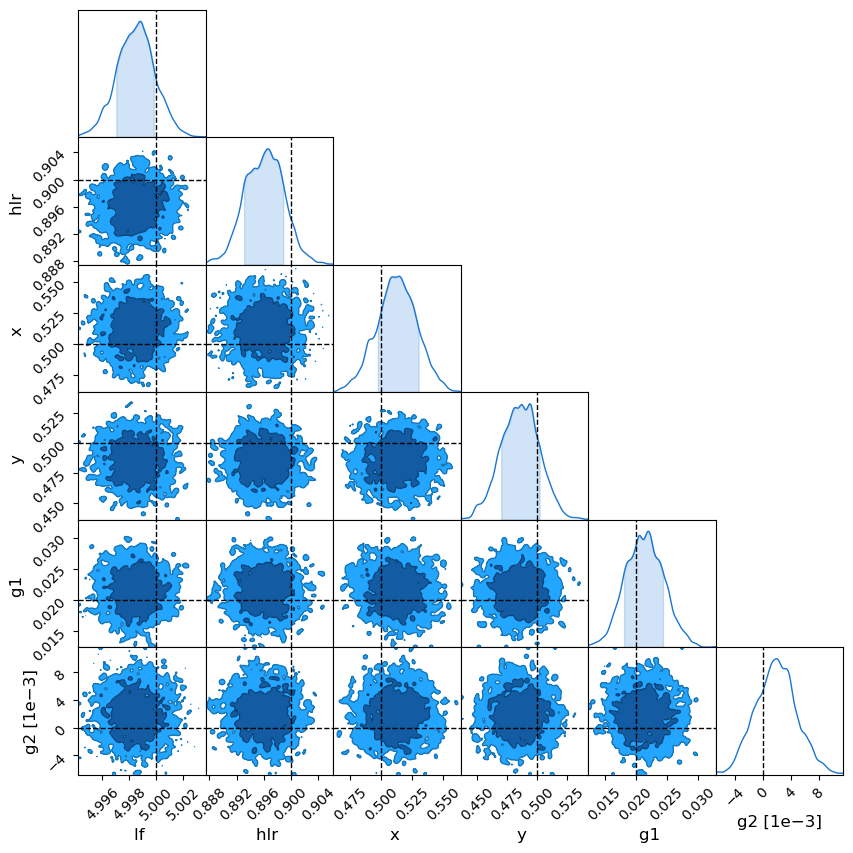

In [227]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['lf', 'hlr', 'x', 'y', 'g1', 'g2']},
    name='Posterior'
)
fig = c.plotter.plot(truth=TRUE_PARAMS)